In [14]:
import numpy as np
from scipy.linalg import norm


class GK:
    def __init__(self, n_clusters=4, max_iter=100, m=2, error=1e-6):
        super().__init__()
        self.u, self.centers, self.f = None, None, None
        self.clusters_count = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error

    def fit(self, z):
        N = z.shape[0]
        C = self.clusters_count
        centers = []

        u = np.random.dirichlet(np.ones(N), size=C)

        iteration = 0
        while iteration < self.max_iter:
            u2 = u.copy()

            centers = self.next_centers(z, u)
            f = self._covariance(z, centers, u)
            dist = self._distance(z, centers, f)
            u = self.next_u(dist)
            iteration += 1

            # Stopping rule
            if norm(u - u2) < self.error:
                break

        self.f = f
        self.u = u
        self.centers = centers
        return centers

    def next_centers(self, z, u):
        um = u ** self.m
        return ((um @ z).T / um.sum(axis=1)).T

    def _covariance(self, z, v, u):
        um = u ** self.m

        denominator = um.sum(axis=1).reshape(-1, 1, 1)
        temp = np.expand_dims(z.reshape(z.shape[0], 1, -1) - v.reshape(1, v.shape[0], -1), axis=3)
        temp = np.matmul(temp, temp.transpose((0, 1, 3, 2)))
        numerator = um.transpose().reshape(um.shape[1], um.shape[0], 1, 1) * temp
        numerator = numerator.sum(0)

        return numerator / denominator

    def _distance(self, z, v, f):
        dif = np.expand_dims(z.reshape(z.shape[0], 1, -1) - v.reshape(1, v.shape[0], -1), axis=3)
        determ = np.power(np.linalg.det(f), 1 / self.m)
        det_time_inv = determ.reshape(-1, 1, 1) * np.linalg.pinv(f)
        temp = np.matmul(dif.transpose((0, 1, 3, 2)), det_time_inv)
        output = np.matmul(temp, dif).squeeze().T
        return np.fmax(output, 1e-8)

    def next_u(self, d):
        power = float(1 / (self.m - 1))
        d = d.transpose()
        denominator_ = d.reshape((d.shape[0], 1, -1)).repeat(d.shape[-1], axis=1)
        denominator_ = np.power(d[:, None, :] / denominator_.transpose((0, 2, 1)), power)
        denominator_ = 1 / denominator_.sum(1)
        denominator_ = denominator_.transpose()

        return denominator_

    def predict(self, z):
        if len(z.shape) == 1:
            z = np.expand_dims(z, axis=0)

        dist = self._distance(z, self.centers, self.f)
        if len(dist.shape) == 1:
            dist = np.expand_dims(dist, axis=0)

        u = self.next_u(dist)
        return np.argmax(u, axis=0)
    

        
                
        

In [59]:
import numpy as np
import pandas as pd

#np.seterr(all='ignore')
class MakeClusterName:
    normData = []
    def __init__(self, clusterAlghoritm, eps = 0.1, shablon1 ='',shablon2=' ',shablon3 = ''):
        self.a = clusterAlghoritm
        self.eps = eps
        self.namesX = []
        self.namesY = []
        self.shablonStart = shablon1
        self.shablonBetween = shablon2
        self.shablonEnd = shablon3
        
    def makeNames(self,data,X_names, Y_names , Normalize = False):
        a = self.a
        n_clusters = a.clusters_count
        maxX = max(data[:,0])
        minX = min(data[:,0])
        maxY = max(data[:,1])
        minY = min(data[:,1])
        
        m = np.zeros(2)
        m[0]= int(len(X_names))
        m[1]= int(len(Y_names))
        granici_x , granici_y = self._zone(maxX, minX, maxY, minY, m)
        print(granici_x,' - ', granici_y)
        if Normalize == False:
            self.namesX,self.namesY = self._getname(a,data, granici_x,granici_y,n_clusters, X_names, Y_names)
        if Normalize == True:
            if len(X_names) != 3 and len(Y_names) != 3:
                print("Number of objects more or less then three. This can cause an error. Check your names list")
            self.namesX, self.namesY = self._getNormName(a,data, n_clusters, X_names, Y_names);
            
        return self.namesX,self.namesY #= self.getname(a,data, granici_x,granici_y,n_clusters, X_names, Y_names)
        
    def _zone(self,max_x,min_x,max_y,min_y, m): # функция для определения границ
        shag_x = round((max_x-min_x)/m[0], 1)
        shag_y = round((max_y-min_y)/m[1], 1)
        granici_x = [[0]*2 for i in range(int(m[0]))]
        granici_y = [[0]*2 for i in range(int(m[1]))]
        zonex = min_x
        zoney = min_y
        
        for j in range(2):
            if j == 0: 
                for x in granici_x:
                    x[0] = zonex
                    x[1] = zonex+shag_x
                    zonex = zonex+shag_x
            if j == 1:
                for y in granici_y:
                    y[0] = zoney
                    y[1] = zoney+shag_y
                    zoney = zoney+shag_y
        return granici_x , granici_y           
        
    def _getname(self,algorithm,data, granici_x, granici_y, n_clusters, name_x, name_y):
        numofVectors = data.shape[0]
        names_x = [0]*n_clusters
        names_y = [0]*n_clusters
        
        for j in range(int(n_clusters)):
            counter_x = np.zeros(len(granici_x))
            counter_y = np.zeros(len(granici_y))
            u_x =np.zeros(len(granici_x))
            u_y =np.zeros(len(granici_y))
            for i in range(numofVectors):            
                if algorithm.u[j][i]>0.5:
                    l = 0
                    while l < len(granici_x):
                        if data[i][0]>granici_x[l][0] and data[i][0]<=granici_x[l][1]:
                            counter_x[l]+=1
                        l+=1
                    l = 0
                    while l < len(granici_y):
                        if data[i][1]>granici_y[l][0] and data[i][1]<=granici_y[l][1]:
                            counter_y[l]+=1
                        l+=1
            
            for i in range(int(counter_x.shape[0])):
                u_x[i] = counter_x[i]/sum(counter_x)
            for i in range(int(counter_y.shape[0])):
                u_y[i] = counter_y[i]/sum(counter_y)
                
            names_x[j] = self._nameOnerow(u_x,name_x)
            names_y[j] = self._nameOnerow(u_y,name_y)      
        return names_x, names_y
    
    def _nameOnerow(self,u_x , name_x):# начинаю давать имена
        names = ''
        print("u_x ", u_x)
        for i in range(u_x.shape[0]):
            
            if u_x[i]<self.eps:
                continue
                
            else:
                k = i
                maxim = i
                while k < u_x.shape[0]:
                    if u_x[maxim]<u_x[k]:
                        maxim = k
                    k+=1
                if maxim != u_x.shape[0]-1 and maxim != 0:
                    if abs(u_x[maxim] - u_x[maxim+1])< self.eps and u_x[maxim+1]> u_x[maxim-1]:
                        names = name_x[maxim]+' and '+name_x[maxim+1]
                        break
                    elif abs(u_x[maxim] - u_x[maxim-1])< self.eps and u_x[maxim+1]< u_x[maxim-1]:
                        names = name_x[maxim-1]+' and '+name_x[maxim]
                        break
                    else:
                        names = name_x[maxim]
                        break
                elif maxim == 0:
                    if abs(u_x[maxim] - u_x[maxim+1])< self.eps:
                        names = name_x[maxim]+' and '+name_x[maxim+1]
                        break
                    else:
                        names = name_x[maxim]
                        break
                elif maxim == u_x.shape[0]-1:
                    if abs(u_x[maxim] - u_x[maxim-1])< self.eps:
                        names = name_x[maxim-1]+' and '+name_x[maxim]
                        break
                    else:
                        names = name_x[maxim]
                        break
        return names
    
    def showCluster(self,data,nameX ='0',nameY ='0'):
        a = self.a
        n_clusters = self.a.clusters_count
        names_x = self.namesX
        names_y = self.namesY
        if nameX !='0' and nameY !='0':
            for i in range(n_clusters):
                if nameX == names_x[i] and nameY == names_y[i]:
                    self._printCluster(a,data,i)
        elif nameX !='0' and nameY =='0':
            for i in range(n_clusters):
                if nameX == names_x[i]:
                    self._printCluster(a,data,i)
        elif nameX =='0' and nameY !='0':
            for i in range(n_clusters):
                if nameY == names_y[i]:
                    self._printCluster(a,data,i)
        else:
            print ('Enter "nameX" or "nameY" ')
    
    def _normalize(self, data):
        normData = pd.DataFrame(data)
        test_df_norm = (normData[0] - normData[0].min()) / (normData[0].max() - normData[0].min())
        test_df_norm = pd.DataFrame(test_df_norm)
        test_df_norm[1] = (normData[1] - normData[1].min()) / (normData[1].max() - normData[1].min())
        self.normData = test_df_norm.values
        return np.array(test_df_norm.values)
    
    def _getNormName(self, a,data, n_clusters, name_x, name_y):
        dataNorm = self._normalize(data)
        numofVectors = data.shape[0]
        sumCounter =[0]*n_clusters
        names_x = [0]*n_clusters
        names_y = [0]*n_clusters
        granici_x = [[0, 0.4],[0.3, 0.7],[0.6, 1]]
        granici_y = [[0, 0.4],[0.3, 0.7],[0.6, 1]]
        for j in range(int(n_clusters)):
            for i in range(numofVectors):
                if a.u[j][i]>0.5:
                    sumCounter[j] += 1
            
        for j in range(int(n_clusters)):
            counter_x = np.zeros(len(granici_x))
            counter_y = np.zeros(len(granici_y))
            u_x =np.zeros(len(granici_x))
            u_y =np.zeros(len(granici_y))
            for i in range(numofVectors):            
                if a.u[j][i]>0.5:
                    l = 0
                    while l < len(granici_x):
                        if dataNorm[i][0]>=granici_x[l][0]:
                            if dataNorm[i][0]<=granici_x[l][1]:
                                counter_x[l]+=1
                                print('x - ',dataNorm[i][0], ' in ', granici_x[l][0],'-',granici_x[l][1])
                        l+=1
                    l = 0
                    while l < len(granici_y):
                        if dataNorm[i][1]>=granici_y[l][0]:
                            if dataNorm[i][1]<=granici_y[l][1]:
                                counter_y[l]+=1
                                print('y - ',dataNorm[i][1], ' in ', granici_y[l][0],'-',granici_y[l][1])
                        l+=1
            
            for i in range(int(counter_x.shape[0])):
                print('couter_x ', counter_x[i],"    " , sumCounter[j])
                u_x[i] = counter_x[i]/sumCounter[j]
            for i in range(int(counter_y.shape[0])):
                print('counter_y',counter_y[i],"    " , sumCounter[j])
                u_y[i] = counter_y[i]/sumCounter[j]
                
            names_x[j] = self._nameOnerow(u_x,name_x)
            names_y[j] = self._nameOnerow(u_y,name_y)      
        return names_x, names_y
    
    def _printCluster(self,a,data,clusterNummber):
        print('cluster № ',clusterNummber, ':')
        print('cluster name - ',self.shablonStart, self.namesX[clusterNummber],self.shablonBetween, self.namesY[clusterNummber], self.shablonEnd, sep='')
        for i in range(data.shape[0]):
            if a.u[clusterNummber][i]>0.5:
                print(data[i])
        """            
        for i in range(numOfVectors):
            if algorithm.u[0][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='red',marker='o', s=15)
            if algorithm.u[1][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='green',marker='o', s=15)
            if algorithm.u[2][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='blue',marker='o', s=15)
            if numOfClusters>3:
                if algorithm.u[3][i]>0.5:
                    plot.scatter(data[i][0],data[i][1],c='black',marker='o', s=15)
        """
        
        
        

In [60]:
import numpy as np
import sys
from scipy.spatial.distance import euclidean

def clusterSeparability(centroids):
    distances=[]
    for centroidIndex, centroid in enumerate(centroids):
        for rest in centroids[centroidIndex+1:]:
            dist=euclidean(centroid,rest)
            distances.append(dist)
    minDistance=np.min(distances)
    return minDistance

def clusterCompactness(data, centroids, uMatrix, expWeight):
    numOfVectors=data.shape[0]
    compactness=0
    for itemIndex, item in enumerate(data):
        for centroidIndex, centroid in enumerate(centroids):
            compactness+=(uMatrix[centroidIndex][itemIndex]**expWeight) * euclidean(item,centroid)
    return compactness

def XieBeniIndex(data, centroids, uMatrix, expWeight=2):
    compactness=clusterCompactness(data, centroids, uMatrix, expWeight)
    separability=numOfVectors*clusterSeparability(centroids)
    return compactness/separability

def KwonIndex(data, centroids, uMatrix):
    numOfClusters=centroids.shape[0]
    grandMean=np.mean(data,axis=0)
    penalty=0
    for centroid in centroids:
        penalty+=euclidean(grandMean, centroid)
    penalty/=numOfClusters
    compactness=penalty+clusterCompactness(data, centroids, uMatrix, expWeight=2)
    separability=clusterSeparability(centroids)
    return compactness/separability

def TangSunSunIndex(data, centroids, uMatrix):
    numOfClusters=centroids.shape[0]
    comp1stTerm=clusterCompactness(data, centroids, uMatrix, expWeight=2)
    comp2ndTerm=0
    for cIndex,c in enumerate(centroids):
        for c2Index,c2 in enumerate(centroids[cIndex+1:]):
            comp2ndTerm+=euclidean(c,c2)
    comp2ndTerm/=numOfClusters*(numOfClusters-1)
    compactness=comp1stTerm+comp2ndTerm
    separability=1.0/numOfClusters+clusterSeparability(centroids)
    return compactness/separability

def FukuyamaSugenoIndex(data, centroids, uMatrix, expWeight=2):
    index=0
    grandMean=np.mean(data, axis=0)
    comp1stTerm=clusterCompactness(data, centroids, uMatrix, expWeight)
    numOfClusters=centroids.shape[0]
    numOfVectors=data.shape[0]
    comp2ndTerm=0
    for i in range(numOfVectors):
        for j in range(numOfClusters):
            comp2ndTerm+=(uMatrix[j][i]**expWeight)*euclidean(grandMean, centroids[j])
    return comp1stTerm+comp2ndTerm

def FuzzySimplifiedSilhouette(data, centroids, uMatrix, weightingFactor=2):
    uMatrixT=uMatrix.T
    uMatrixSortT=-np.sort(-uMatrixT)
    indices=np.argmax(uMatrix,axis=0)
    numerator=0
    divisor=0
    for itemIndex, item in enumerate(data):
        minDistanceInTheSameCluster=sys.maxsize
        minDistanceInTheDifferentCluster=sys.maxsize
        for item2Index,item2 in enumerate(data):
            if itemIndex!=item2Index:
                distance=euclidean(item,item2)
                if indices[itemIndex]==indices[item2Index]:
                    if distance<minDistanceInTheSameCluster:
                        minDistanceInTheSameCluster=distance
                else:
                    if distance<minDistanceInTheDifferentCluster:
                        minDistanceInTheDifferentCluster=distance
        silhouette=(minDistanceInTheDifferentCluster-minDistanceInTheSameCluster) \
        / max(minDistanceInTheDifferentCluster,minDistanceInTheSameCluster)
        fuzzyFactor=(uMatrixSortT[itemIndex][0]-uMatrixSortT[itemIndex][1])**weightingFactor
        numerator+=fuzzyFactor*silhouette
        divisor+=fuzzyFactor                       
    return numerator/divisor

In [61]:
import sys
import pandas as pd
pd.set_option('display.max_rows',350)
np.set_printoptions(threshold=sys.maxsize)

#numOfVectors=70
df=pd.read_csv('dataset_fuzzy_2020_csv_ext3.csv',sep=',',encoding="cp1251")

#df=df.loc[df['Profit2016']<30]
#df=df.loc[df['Profit2016']>-5]
#df=df.loc[df['Deprication2012']>0]
#df=df.loc[df['Earnings2012']<80000]
#df=df.loc[df['Investments2012']<120000]
#df_small=df[['Investments2012','Investments2013']]

#df_small=df[['Costs2012','Earnings2012']]



In [62]:
df[['Name','Profit2016','Energy2016','Deprication2012','Investments2012']]

,Name,Profit2016,Energy2016,Deprication2012,Investments2012
0,Белгородская область,14.51,15258.8,41.9,88929
1,Брянская область,6.99,3881.9,46.0,36974
2,Владимирская область,9.55,7138.2,43.2,42761
3,Воронежская область,8.90,11278.0,44.7,78223
4,Ивановская область,2.38,3508.8,39.3,27353
5,Калужская область,2.96,7184.1,39.1,95312
6,Костромская область,10.82,3716.2,45.3,32059
7,Курская область,16.50,9436.3,49.1,59477
8,Липецкая область,15.11,12637.6,51.2,80173
9,Московская область,6.29,43960.2,39.7,73822


In [63]:
df.describe()

,Profit2016,Profit2017,Energy2016,Energy2017,Deprication2012,Deprication2013,Investments2012,Investments2013,Costs2012,Costs2013,Earnings2012,Earnings2013
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,8.500000e+01,85.000000,85.000000,85.000000,85.000000,85.000000
mean,10.812118,11.362941,13835.172941,13954.537647,42.748235,43.144706,1.012652e+05,96348.447059,8.801176,8.858824,20385.270588,22703.741176
std,8.515206,9.299445,17033.349445,17091.123929,11.597081,11.270722,1.334332e+05,119088.603893,2.331998,2.243259,8415.751809,9367.010978
min,-10.270000,-8.880000,489.900000,504.400000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.400000,6.740000,3881.900000,3900.000000,38.000000,37.800000,4.843900e+04,48452.000000,8.000000,8.000000,16229.000000,18012.000000
50%,9.610000,9.760000,8502.400000,8447.700000,43.600000,43.400000,6.160300e+04,63213.000000,8.900000,8.900000,18305.000000,20513.000000
75%,14.740000,14.150000,15258.800000,14958.700000,51.300000,50.500000,1.020780e+05,91452.000000,9.900000,9.900000,21800.000000,24731.000000
max,38.630000,46.080000,98041.400000,97031.400000,63.200000,64.800000,1.077770e+06,932956.000000,13.600000,13.900000,52585.000000,58040.000000


In [64]:
df.columns

Index(['Name', 'Profit2016', 'Profit2017', 'Energy2016', 'Energy2017',
       'Deprication2012', 'Deprication2013', 'Investments2012',
       'Investments2013', 'Costs2012', 'Costs2013', 'Earnings2012',
       'Earnings2013'],
      dtype='object')

In [65]:
low = .05
high = .95
quant_df=df.quantile([low, high])
print(quant_df)

#print(quant_df.loc[low,'Profit2016'])

"""
df=df.loc[(df['Profit2016']>quant_df.loc[low,'Profit2016'])&((df['Profit2016']<quant_df.loc[high,'Profit2016']))]
df=df.loc[(df['Profit2017']>quant_df.loc[low,'Profit2017'])&((df['Profit2017']<quant_df.loc[high,'Profit2017']))]
df=df.loc[(df['Energy2016']>quant_df.loc[low,'Energy2016'])&((df['Energy2016']<quant_df.loc[high,'Energy2016']))]
df=df.loc[(df['Energy2017']>quant_df.loc[low,'Energy2017'])&((df['Energy2017']<quant_df.loc[high,'Energy2017']))]
df=df.loc[(df['Deprication2012']>quant_df.loc[low,'Deprication2012'])&
          ((df['Deprication2012']<quant_df.loc[high,'Deprication2012']))]
df=df.loc[(df['Deprication2013']>quant_df.loc[low,'Deprication2013'])&
          ((df['Deprication2013']<quant_df.loc[high,'Deprication2013']))]
df=df.loc[(df['Investments2012']>quant_df.loc[low,'Investments2012'])&
          ((df['Investments2012']<quant_df.loc[high,'Investments2012']))]
df=df.loc[(df['Investments2013']>quant_df.loc[low,'Investments2013'])&
          ((df['Investments2013']<quant_df.loc[high,'Investments2013']))]
df=df.loc[(df['Costs2012']>quant_df.loc[low,'Costs2012'])&((df['Costs2012']<quant_df.loc[high,'Costs2012']))]
df=df.loc[(df['Costs2013']>quant_df.loc[low,'Costs2013'])&((df['Costs2013']<quant_df.loc[high,'Costs2013']))]
df=df.loc[(df['Earnings2012']>quant_df.loc[low,'Earnings2012'])&((df['Earnings2012']<quant_df.loc[high,'Earnings2012']))]
df=df.loc[(df['Earnings2013']>quant_df.loc[low,'Earnings2013'])&((df['Earnings2013']<quant_df.loc[high,'Earnings2013']))]
"""

#a='Profit2016'
#print(quant_df.loc[low,a])
#df = df.apply(lambda x: x[(x>quant_df.loc[low,x.name])&(x < quant_df.loc[high,x.name])], axis=0)
#for attr in df.columns:
#    value=quant_df.loc[low,attr]
#    print('Value =',value)
#    df=df.loc[attr>value]
#    df=df.loc[attr<quant_df.loc[high,attr]]    

      Profit2016  Profit2017  Energy2016  Energy2017  Deprication2012  \
0.05      -0.372       0.298      914.84      904.22            25.42   
0.95      29.768      31.038    52094.30    51871.62            59.42   

      Deprication2013  Investments2012  Investments2013  Costs2012  Costs2013  \
0.05            27.12          31117.4          30332.6       5.74       5.52   
0.95            58.68         317908.6         211193.8      12.28      12.36   

      Earnings2012  Earnings2013  
0.05       12364.0       13943.4  
0.95       35770.6       39835.2  


"\ndf=df.loc[(df['Profit2016']>quant_df.loc[low,'Profit2016'])&((df['Profit2016']<quant_df.loc[high,'Profit2016']))]\ndf=df.loc[(df['Profit2017']>quant_df.loc[low,'Profit2017'])&((df['Profit2017']<quant_df.loc[high,'Profit2017']))]\ndf=df.loc[(df['Energy2016']>quant_df.loc[low,'Energy2016'])&((df['Energy2016']<quant_df.loc[high,'Energy2016']))]\ndf=df.loc[(df['Energy2017']>quant_df.loc[low,'Energy2017'])&((df['Energy2017']<quant_df.loc[high,'Energy2017']))]\ndf=df.loc[(df['Deprication2012']>quant_df.loc[low,'Deprication2012'])&\n          ((df['Deprication2012']<quant_df.loc[high,'Deprication2012']))]\ndf=df.loc[(df['Deprication2013']>quant_df.loc[low,'Deprication2013'])&\n          ((df['Deprication2013']<quant_df.loc[high,'Deprication2013']))]\ndf=df.loc[(df['Investments2012']>quant_df.loc[low,'Investments2012'])&\n          ((df['Investments2012']<quant_df.loc[high,'Investments2012']))]\ndf=df.loc[(df['Investments2013']>quant_df.loc[low,'Investments2013'])&\n          ((df['Investme

In [66]:
df.describe()

,Profit2016,Profit2017,Energy2016,Energy2017,Deprication2012,Deprication2013,Investments2012,Investments2013,Costs2012,Costs2013,Earnings2012,Earnings2013
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,8.500000e+01,85.000000,85.000000,85.000000,85.000000,85.000000
mean,10.812118,11.362941,13835.172941,13954.537647,42.748235,43.144706,1.012652e+05,96348.447059,8.801176,8.858824,20385.270588,22703.741176
std,8.515206,9.299445,17033.349445,17091.123929,11.597081,11.270722,1.334332e+05,119088.603893,2.331998,2.243259,8415.751809,9367.010978
min,-10.270000,-8.880000,489.900000,504.400000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.400000,6.740000,3881.900000,3900.000000,38.000000,37.800000,4.843900e+04,48452.000000,8.000000,8.000000,16229.000000,18012.000000
50%,9.610000,9.760000,8502.400000,8447.700000,43.600000,43.400000,6.160300e+04,63213.000000,8.900000,8.900000,18305.000000,20513.000000
75%,14.740000,14.150000,15258.800000,14958.700000,51.300000,50.500000,1.020780e+05,91452.000000,9.900000,9.900000,21800.000000,24731.000000
max,38.630000,46.080000,98041.400000,97031.400000,63.200000,64.800000,1.077770e+06,932956.000000,13.600000,13.900000,52585.000000,58040.000000


In [67]:

df_small=df[['Deprication2012','Investments2012']]
data_in=df_small.values
df_small

,Deprication2012,Investments2012
0,41.9,88929
1,46.0,36974
2,43.2,42761
3,44.7,78223
4,39.3,27353
5,39.1,95312
6,45.3,32059
7,49.1,59477
8,51.2,80173
9,39.7,73822


In [68]:
df_small1=df[['Profit2016','Energy2016']]
data_in1=df_small1.values
df_small1

,Profit2016,Energy2016
0,14.51,15258.8
1,6.99,3881.9
2,9.55,7138.2
3,8.90,11278.0
4,2.38,3508.8
5,2.96,7184.1
6,10.82,3716.2
7,16.50,9436.3
8,15.11,12637.6
9,6.29,43960.2


In [69]:
#data_in=df_small[:numOfVectors].values
#data=data_in
#from sklearn.preprocessing import StandardScaler
#stdsc=StandardScaler()
#data=stdsc.fit_transform(data_in)

data=data_in

numOfClusters=4
maxIterations=100
exponentialWeight=2
tolerance=0.01
algorithm=GK(n_clusters=numOfClusters,max_iter=maxIterations,m=exponentialWeight)
cluster_centroids=algorithm.fit(data)
#names = ['low', 'medium', 'notHigh', 'High']
#name = algorithm.makeName(names)
output=algorithm.predict(data)
#output
#name

In [70]:
data1=data_in1

numOfClusters=4
maxIterations=100
exponentialWeight=2
tolerance=0.01
algorithm1=GK(n_clusters=numOfClusters,max_iter=maxIterations,m=exponentialWeight)
cluster_centroids1=algorithm1.fit(data_in1)
output1=algorithm1.predict(data_in1)

In [71]:
namex =['low', 'medium',  'High']
namey =['low', 'medium',  'High']
named_algorithm1 = MakeClusterName(algorithm1)
named_algorithm1.makeNames(data_in1,namex,namey)

[[-10.27, 6.030000000000001], [6.030000000000001, 22.330000000000002], [22.330000000000002, 38.63]]  -  [[489.9, 33007.1], [33007.1, 65524.3], [65524.3, 98041.5]]
u_x  [0.375   0.46875 0.15625]
u_x  [1. 0. 0.]
u_x  [0. 1. 0.]
u_x  [0.  0.6 0.4]
u_x  [0.07142857 0.85714286 0.07142857]
u_x  [0.71428571 0.28571429 0.        ]
u_x  [0.09090909 0.90909091 0.        ]
u_x  [1. 0. 0.]


(['low and medium', 'medium', 'medium', 'medium'],
 ['low', 'medium', 'low', 'low'])

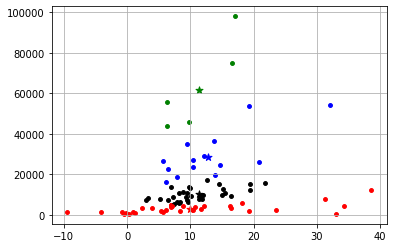

In [72]:
import matplotlib.pyplot as plot

numOfVectors=df.shape[0]
for i in range(numOfVectors):
            if algorithm1.u[0][i]>0.5:
                plot.scatter(data_in1[i][0],data_in1[i][1],c='red',marker='o', s=15)
            if algorithm1.u[1][i]>0.5:
                plot.scatter(data_in1[i][0],data_in1[i][1],c='green',marker='o', s=15)
            if algorithm1.u[2][i]>0.5:
                plot.scatter(data_in1[i][0],data_in1[i][1],c='blue',marker='o', s=15)
            if numOfClusters>3:
                if algorithm1.u[3][i]>0.5:
                    plot.scatter(data_in1[i][0],data_in1[i][1],c='black',marker='o', s=15)

plot.scatter(cluster_centroids1[0][0],cluster_centroids1[0][1],c='red',marker='*',s=55)
plot.scatter(cluster_centroids1[1][0],cluster_centroids1[1][1],c='green',marker='*',s=55)
plot.scatter(cluster_centroids1[2][0],cluster_centroids1[2][1],c='blue',marker='*',s=55)
if numOfClusters>3:
    plot.scatter(cluster_centroids1[3][0],cluster_centroids1[3][1],c='black',marker='*',s=55)

plot.grid()
plot.show()

In [73]:

namex =['low', 'medium',  'High']
namey =['low', 'medium',  'High']
named_algorithm1 = MakeClusterName(algorithm1)
named_algorithm1.makeNames(data_in1,namex,namey, Normalize=True)

[[-10.27, 6.030000000000001], [6.030000000000001, 22.330000000000002], [22.330000000000002, 38.63]]  -  [[489.9, 33007.1], [33007.1, 65524.3], [65524.3, 98041.5]]
x -  0.35296523517382405  in  0 - 0.4
x -  0.35296523517382405  in  0.3 - 0.7
y -  0.03477137717000764  in  0 - 0.4
x -  0.2586912065439672  in  0 - 0.4
y -  0.030946730701219356  in  0 - 0.4
x -  0.43128834355828216  in  0.3 - 0.7
y -  0.033072787194456256  in  0 - 0.4
x -  0.44826175869120655  in  0.3 - 0.7
y -  0.022758235393612603  in  0 - 0.4
x -  0.5460122699386503  in  0.3 - 0.7
y -  0.03161202031747333  in  0 - 0.4
x -  0.3895705521472392  in  0 - 0.4
x -  0.3895705521472392  in  0.3 - 0.7
y -  0.04079383710142847  in  0 - 0.4
x -  1.0  in  0.6 - 1
y -  0.12159320974049605  in  0 - 0.4
x -  0.5439672801635991  in  0.3 - 0.7
y -  0.041300236285449224  in  0 - 0.4
x -  0.32085889570552145  in  0 - 0.4
x -  0.32085889570552145  in  0.3 - 0.7
y -  0.015648144826066232  in  0 - 0.4
x -  0.3269938650306748  in  0 - 0.4
x - 

(['low and medium', 'medium', 'medium', 'medium'],
 ['low', 'medium', 'low', 'low'])

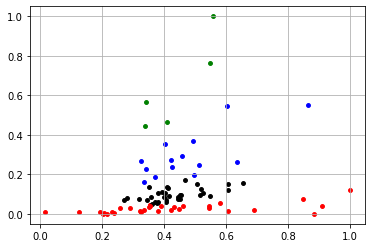

In [74]:
import matplotlib.pyplot as plot
normData = named_algorithm1.normData
numOfVectors=df.shape[0]
for i in range(numOfVectors):
            if algorithm1.u[0][i]>0.5:
                plot.scatter(normData[i][0],normData[i][1],c='red',marker='o', s=15)
            if algorithm1.u[1][i]>0.5:
                plot.scatter(normData[i][0],normData[i][1],c='green',marker='o', s=15)
            if algorithm1.u[2][i]>0.5:
                plot.scatter(normData[i][0],normData[i][1],c='blue',marker='o', s=15)
            if numOfClusters>3:
                if algorithm1.u[3][i]>0.5:
                    plot.scatter(normData[i][0],normData[i][1],c='black',marker='o', s=15)

#plot.scatter(cluster_centroids1[0][0],cluster_centroids1[0][1],c='red',marker='*',s=55)
#plot.scatter(cluster_centroids1[1][0],cluster_centroids1[1][1],c='green',marker='*',s=55)
#plot.scatter(cluster_centroids1[2][0],cluster_centroids1[2][1],c='blue',marker='*',s=55)
#if numOfClusters>3:
 #   plot.scatter(cluster_centroids1[3][0],cluster_centroids1[3][1],c='black',marker='*',s=55)

plot.grid()
plot.show()

In [75]:

namex =['low', 'medium',  'High']
namey =['low', 'medium',  'High']
named_algorithm = MakeClusterName(algorithm)
named_algorithm.makeNames(data,namex,namey)


[[0.0, 21.1], [21.1, 42.2], [42.2, 63.300000000000004]]  -  [[0.0, 359256.7], [359256.7, 718513.4], [718513.4, 1077770.1]]
u_x  [0. 0. 1.]
u_x  [1. 0. 0.]
u_x  [0.         0.76923077 0.23076923]
u_x  [1. 0. 0.]
u_x  [0.         0.33333333 0.66666667]
u_x  [0.66666667 0.33333333 0.        ]
u_x  [0.         0.66666667 0.33333333]
u_x  [0.66666667 0.         0.33333333]


(['High', 'medium', 'High', 'medium'], ['low', 'low', 'low', 'low'])

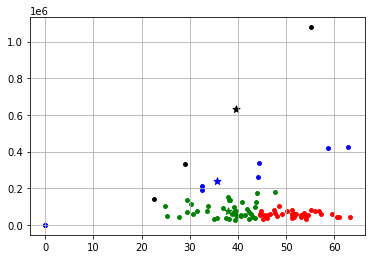

In [76]:
import matplotlib.pyplot as plot

for i in range(numOfVectors):
            if algorithm.u[0][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='red',marker='o', s=15)
            if algorithm.u[1][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='green',marker='o', s=15)
            if algorithm.u[2][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='blue',marker='o', s=15)
            if numOfClusters>3:
                if algorithm.u[3][i]>0.5:
                    plot.scatter(data[i][0],data[i][1],c='black',marker='o', s=15)

plot.scatter(cluster_centroids[0][0],cluster_centroids[0][1],c='red',marker='*',s=55)
plot.scatter(cluster_centroids[1][0],cluster_centroids[1][1],c='green',marker='*',s=55)
plot.scatter(cluster_centroids[2][0],cluster_centroids[2][1],c='blue',marker='*',s=55)
if numOfClusters>3:
    plot.scatter(cluster_centroids[3][0],cluster_centroids[3][1],c='black',marker='*',s=55)

plot.grid()
plot.show()

In [77]:
namex =['low', 'medium',  'High']
namey =['low', 'medium',  'High']
named_algorithm = MakeClusterName(algorithm)
named_algorithm.makeNames(data,namex,namey, Normalize=True)


[[0.0, 21.1], [21.1, 42.2], [42.2, 63.300000000000004]]  -  [[0.0, 359256.7], [359256.7, 718513.4], [718513.4, 1077770.1]]
x -  0.7278481012658228  in  0.6 - 1
y -  0.034306020765098304  in  0 - 0.4
x -  0.7072784810126582  in  0.6 - 1
y -  0.0725785649999536  in  0 - 0.4
x -  0.7167721518987341  in  0.6 - 1
y -  0.029745678577061896  in  0 - 0.4
x -  0.7768987341772152  in  0.6 - 1
y -  0.055185243604850755  in  0 - 0.4
x -  0.810126582278481  in  0.6 - 1
y -  0.07438785640721118  in  0 - 0.4
x -  0.7294303797468354  in  0.6 - 1
y -  0.04818096625439565  in  0 - 0.4
x -  0.8212025316455696  in  0.6 - 1
y -  0.05398090501684033  in  0 - 0.4
x -  0.7056962025316456  in  0.6 - 1
y -  0.05354945860434045  in  0 - 0.4
x -  0.8844936708860759  in  0.6 - 1
y -  0.07129443202167439  in  0 - 0.4
x -  0.7041139240506329  in  0.6 - 1
y -  0.050694489547862716  in  0 - 0.4
x -  0.7563291139240506  in  0.6 - 1
y -  0.05912764318917765  in  0 - 0.4
x -  0.7626582278481012  in  0.6 - 1
y -  0.044943

(['High', 'medium', 'High', 'medium'], ['low', 'low', 'low', 'low'])

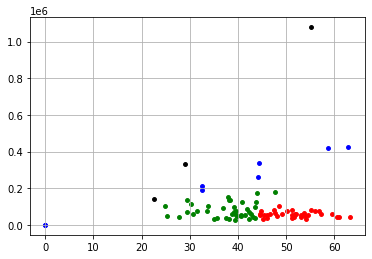

In [78]:
import matplotlib.pyplot as plot

normData2 = named_algorithm1.normData
for i in range(numOfVectors):
            if algorithm.u[0][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='red',marker='o', s=15)
            if algorithm.u[1][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='green',marker='o', s=15)
            if algorithm.u[2][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='blue',marker='o', s=15)
            if numOfClusters>3:
                if algorithm.u[3][i]>0.5:
                    plot.scatter(data[i][0],data[i][1],c='black',marker='o', s=15)

#plot.scatter(cluster_centroids[0][0],cluster_centroids[0][1],c='red',marker='*',s=55)
#plot.scatter(cluster_centroids[1][0],cluster_centroids[1][1],c='green',marker='*',s=55)
#plot.scatter(cluster_centroids[2][0],cluster_centroids[2][1],c='blue',marker='*',s=55)
#if numOfClusters>3:
 #   plot.scatter(cluster_centroids[3][0],cluster_centroids[3][1],c='black',marker='*',s=55)

plot.grid()
plot.show()

In [79]:
named_algorithm.showCluster(data, nameX = 'High')

cluster №  0 :
cluster name - High low
[   46. 36974.]
[4.4700e+01 7.8223e+04]
[   45.3 32059. ]
[4.9100e+01 5.9477e+04]
[5.1200e+01 8.0173e+04]
[4.6100e+01 5.1928e+04]
[5.1900e+01 5.8179e+04]
[4.4600e+01 5.7714e+04]
[5.5900e+01 7.6839e+04]
[4.4500e+01 5.4637e+04]
[4.7800e+01 6.3726e+04]
[4.8200e+01 4.8439e+04]
[4.7500e+01 8.0505e+04]
[5.1300e+01 5.2591e+04]
[   54.2 33864. ]
[   53.1 41417. ]
[   51.7 41349. ]
[5.2100e+01 5.7521e+04]
[   60.6 45787. ]
[5.7300e+01 6.0613e+04]
[   61. 42309.]
[   54.6 52404. ]
[5.9600e+01 6.1624e+04]
[   51.3 38191. ]
[5.0200e+01 7.8173e+04]
[5.6900e+01 7.4881e+04]
[   53.2 52705. ]
[5.3700e+01 6.6286e+04]
[   54. 46945.]
[4.6600e+01 5.7095e+04]
[   63.2 40642. ]
[5.5200e+01 8.1554e+04]
[4.5500e+01 5.5364e+04]
[4.86000e+01 1.02078e+05]
cluster №  2 :
cluster name - High low
[4.42000e+01 2.62327e+05]
[3.26000e+01 1.89795e+05]
[0. 0.]
[0. 0.]
[5.87000e+01 4.18058e+05]
[6.28000e+01 4.26725e+05]
[3.26000e+01 2.14713e+05]
[4.44000e+01 3.39671e+05]


In [80]:
s = 'lowground'
'low' in s

True

In [81]:
cluster_centroids

array([[5.13668376e+01, 6.03851168e+04],
       [3.78382841e+01, 7.42983106e+04],
       [3.56741530e+01, 2.40053129e+05],
       [3.95056332e+01, 6.30113697e+05]])

In [82]:
p = sorted(cluster_centroids, key=lambda cluster_centroids_entry: cluster_centroids_entry[0])
p

[array([3.56741530e+01, 2.40053129e+05]),
 array([3.78382841e+01, 7.42983106e+04]),
 array([3.95056332e+01, 6.30113697e+05]),
 array([5.13668376e+01, 6.03851168e+04])]

In [83]:
"""
testData=np.zeros((10000,2),dtype=float)
for yIndex in range(100):
        for xIndex in range(100):
            testData[yIndex*20+xIndex,0]=xIndex/100-0.5
            testData[yIndex*20+xIndex,1]=yIndex/100-0.5
print(testData)
output3=algorithm.predict(testData)     
"""

'\ntestData=np.zeros((10000,2),dtype=float)\nfor yIndex in range(100):\n        for xIndex in range(100):\n            testData[yIndex*20+xIndex,0]=xIndex/100-0.5\n            testData[yIndex*20+xIndex,1]=yIndex/100-0.5\nprint(testData)\noutput3=algorithm.predict(testData)     \n'

In [84]:
"""
import matplotlib.pyplot as plot

for i in range(10000):
            if algorithm.u[0][i]>0.5:
                plot.scatter(testData[i][0],testData[i][1],c='red',marker='o', s=15)
            if algorithm.u[1][i]>0.5:
                plot.scatter(testData[i][0],testData[i][1],c='green',marker='o', s=15)
            if algorithm.u[2][i]>0.5:
                plot.scatter(testData[i][0],testData[i][1],c='blue',marker='o', s=15)
            if numOfClusters>3:
                if algorithm.u[3][i]>0.5:
                    plot.scatter(testData[i][0],testData[i][1],c='black',marker='o', s=15)

#plot.scatter(cluster_centroids[0][0],cluster_centroids[0][1],c='red',marker='*',s=55)
#plot.scatter(cluster_centroids[1][0],cluster_centroids[1][1],c='green',marker='*',s=55)
#plot.scatter(cluster_centroids[2][0],cluster_centroids[2][1],c='blue',marker='*',s=55)
#if numOfClusters>3:
#    plot.scatter(cluster_centroids[3][0],cluster_centroids[3][1],c='black',marker='*',s=55)

plot.grid()
plot.show()
"""

"\nimport matplotlib.pyplot as plot\n\nfor i in range(10000):\n            if algorithm.u[0][i]>0.5:\n                plot.scatter(testData[i][0],testData[i][1],c='red',marker='o', s=15)\n            if algorithm.u[1][i]>0.5:\n                plot.scatter(testData[i][0],testData[i][1],c='green',marker='o', s=15)\n            if algorithm.u[2][i]>0.5:\n                plot.scatter(testData[i][0],testData[i][1],c='blue',marker='o', s=15)\n            if numOfClusters>3:\n                if algorithm.u[3][i]>0.5:\n                    plot.scatter(testData[i][0],testData[i][1],c='black',marker='o', s=15)\n\n#plot.scatter(cluster_centroids[0][0],cluster_centroids[0][1],c='red',marker='*',s=55)\n#plot.scatter(cluster_centroids[1][0],cluster_centroids[1][1],c='green',marker='*',s=55)\n#plot.scatter(cluster_centroids[2][0],cluster_centroids[2][1],c='blue',marker='*',s=55)\n#if numOfClusters>3:\n#    plot.scatter(cluster_centroids[3][0],cluster_centroids[3][1],c='black',marker='*',s=55)\n\nplot

In [85]:
numOfVectors=df.shape[0]
print(numOfVectors)

85


In [86]:
numOfClusters_test2=4
maxIterations_test2=100
exponentialWeight_test2=2
tolerance_test2=0.01
algorithm_test2=GK(n_clusters=numOfClusters_test2,max_iter=maxIterations,m=exponentialWeight)
cluster_centroids_test2=algorithm_test2.fit(data)
output_test2=algorithm_test2.predict(data)

In [87]:
df

,Name,Profit2016,Profit2017,Energy2016,Energy2017,Deprication2012,Deprication2013,Investments2012,Investments2013,Costs2012,Costs2013,Earnings2012,Earnings2013
0,Белгородская область,14.51,13.68,15258.8,14576.7,41.9,43.3,88929,83717,7.5,8.0,21659,23735
1,Брянская область,6.99,9.58,3881.9,3900.0,46.0,45.6,36974,48711,9.3,10.2,17469,20152
2,Владимирская область,9.55,10.38,7138.2,7110.5,43.2,43.7,42761,46060,11.2,11.7,16229,18796
3,Воронежская область,8.90,7.64,11278.0,11334.5,44.7,43.0,78223,93050,8.3,7.3,18948,22056
4,Ивановская область,2.38,3.81,3508.8,3521.6,39.3,42.2,27353,30210,10.9,10.0,16015,18123
5,Калужская область,2.96,3.69,7184.1,8154.5,39.1,35.8,95312,89396,7.4,7.9,20742,23182
6,Костромская область,10.82,9.48,3716.2,3714.2,45.3,48.4,32059,33832,8.0,8.3,15867,17575
7,Курская область,16.50,16.08,9436.3,9225.2,49.1,47.9,59477,63213,8.9,10.4,18866,20809
8,Липецкая область,15.11,13.91,12637.6,12789.3,51.2,49.2,80173,87033,9.9,9.0,19829,22222
9,Московская область,6.29,6.66,43960.2,47159.9,39.7,40.5,73822,81034,12.1,12.6,30572,32739


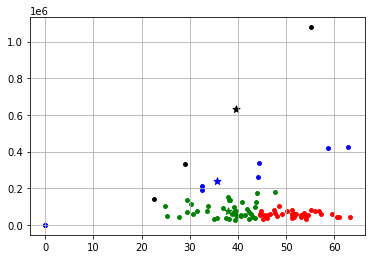

In [88]:
import matplotlib.pyplot as plot

for i in range(numOfVectors):
            if algorithm.u[0][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='red',marker='o', s=15)
            if algorithm.u[1][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='green',marker='o', s=15)
            if algorithm.u[2][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='blue',marker='o', s=15)
            if numOfClusters>3:
                if algorithm.u[3][i]>0.5:
                    plot.scatter(data[i][0],data[i][1],c='black',marker='o', s=15)

plot.scatter(cluster_centroids[0][0],cluster_centroids[0][1],c='red',marker='*',s=55)
plot.scatter(cluster_centroids[1][0],cluster_centroids[1][1],c='green',marker='*',s=55)
plot.scatter(cluster_centroids[2][0],cluster_centroids[2][1],c='blue',marker='*',s=55)
if numOfClusters>3:
    plot.scatter(cluster_centroids[3][0],cluster_centroids[3][1],c='black',marker='*',s=55)

plot.grid()
plot.show()

In [89]:
cluster_centroids[0]

array([5.13668376e+01, 6.03851168e+04])

In [90]:
#from mlxtend.plotting import plot_decision_regions
#plot_decision_regions()

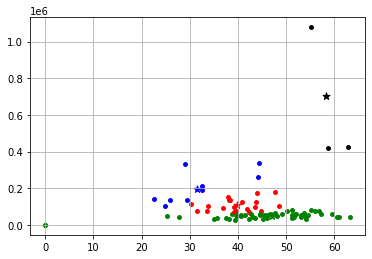

In [91]:
import matplotlib.pyplot as plot

for i in range(numOfVectors):
            if algorithm_test2.u[0][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='red',marker='o', s=15)
            if algorithm_test2.u[1][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='green',marker='o', s=15)
            if algorithm_test2.u[2][i]>0.5:
                plot.scatter(data[i][0],data[i][1],c='blue',marker='o', s=15)
            if numOfClusters_test2>3:
                if algorithm_test2.u[3][i]>0.5:
                    plot.scatter(data[i][0],data[i][1],c='black',marker='o', s=15)

plot.scatter(cluster_centroids_test2[0][0],cluster_centroids_test2[0][1],c='red',marker='*',s=55)
plot.scatter(cluster_centroids_test2[1][0],cluster_centroids_test2[1][1],c='green',marker='*',s=55)
plot.scatter(cluster_centroids_test2[2][0],cluster_centroids_test2[2][1],c='blue',marker='*',s=55)
if numOfClusters_test2>3:
    plot.scatter(cluster_centroids_test2[3][0],cluster_centroids_test2[3][1],c='black',marker='*',s=55)

plot.grid()
plot.show()

In [92]:
xbIndex=XieBeniIndex(data, cluster_centroids, algorithm.u, expWeight=2)
print('Xie-Beni Index =',xbIndex)
kIndex=KwonIndex(data, cluster_centroids, algorithm.u)
print('Kwon Index =',kIndex)
tssIndex=TangSunSunIndex(data, cluster_centroids,algorithm.u)
print('Tang-Sun-Sun Index =',tssIndex)
fsIndex=FukuyamaSugenoIndex(data,cluster_centroids, algorithm.u)
print('Fukuyama-Sugeno Index =',fsIndex)
fss=FuzzySimplifiedSilhouette(data, cluster_centroids, algorithm.u, weightingFactor=2)
print('Fuzzy Simplified Silhouette Index =',fss)

Xie-Beni Index = 2.391180358112121
Kwon Index = 216.46589878640896
Tang-Sun-Sun Index = 214.4764627628443
Fukuyama-Sugeno Index = 6719380.508132288
Fuzzy Simplified Silhouette Index = 0.20840893852916018


In [93]:
xbIndex_test2=XieBeniIndex(data, cluster_centroids_test2, algorithm_test2.u, expWeight=2)
print('Xie-Beni Index =',xbIndex_test2)
kIndex_test2=KwonIndex(data, cluster_centroids_test2, algorithm_test2.u)
print('Kwon Index =',kIndex_test2)
tssIndex_test2=TangSunSunIndex(data, cluster_centroids_test2,algorithm_test2.u)
print('Tang-Sun-Sun Index =',tssIndex_test2)
fsIndex_test2=FukuyamaSugenoIndex(data,cluster_centroids_test2, algorithm_test2.u)
print('Fukuyama-Sugeno Index =',fsIndex_test2)
fss_test2=FuzzySimplifiedSilhouette(data, cluster_centroids_test2, algorithm_test2.u, weightingFactor=2)
print('Fuzzy Simplified Silhouette Index =',fss_test2)

Xie-Beni Index = 0.43354467974255717
Kwon Index = 40.26292568381734
Tang-Sun-Sun Index = 39.94784394257518
Fukuyama-Sugeno Index = 5834027.776861394
Fuzzy Simplified Silhouette Index = 0.6923177637240743
